<a href="https://colab.research.google.com/github/CHIEN-CHOU-WU/Mnist_Model/blob/main/Hand_Write.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
%matplotlib inline

# **資訊**

**檢查 Python 和 CUDA 版本**

In [82]:
!python --version
!nvidia-smi
!nvcc --version

Python 3.7.10
Thu Apr 29 01:16:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |   1094MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#**建立，訓練模型**

In [84]:
dataset = MNIST(root='data/', 
                download=True,
                train=True,
                transform=transforms.ToTensor())

train_ds, val_ds = random_split(dataset, [50000, 10000])

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

img_tensor, label = dataset[0]
img_tensor.shape

torch.Size([1, 28, 28])

In [85]:
input_size = 28*28
num_classes = 10    # [0, 1, 2, 3, 4, 5, 6 ,7 ,8 ,9]

In [86]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)    # 制定優化器，放入神經網路
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()                         # 微分 loss
            optimizer.step()                        # 更新 loss 梯度
            optimizer.zero_grad()                   # 歸零梯度
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)              # 打印文字
        history.append(result)

    return history

In [87]:
l1 = [1, 2, 3, 4, 5]
l2 = [x*2 for x in l1]

In [88]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [89]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                  # Generate predictions (跑 forwad 函數產出預測)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()
model.to(device)

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [90]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [91]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.10759493708610535, 'val_loss': 2.320953845977783}

In [92]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9416, val_acc: 0.6154
Epoch [1], val_loss: 1.6721, val_acc: 0.7281
Epoch [2], val_loss: 1.4709, val_acc: 0.7624
Epoch [3], val_loss: 1.3190, val_acc: 0.7840
Epoch [4], val_loss: 1.2022, val_acc: 0.7988


In [93]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1106, val_acc: 0.8084
Epoch [1], val_loss: 1.0372, val_acc: 0.8162
Epoch [2], val_loss: 0.9773, val_acc: 0.8229
Epoch [3], val_loss: 0.9275, val_acc: 0.8277
Epoch [4], val_loss: 0.8855, val_acc: 0.8315


In [94]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8494, val_acc: 0.8352
Epoch [1], val_loss: 0.8183, val_acc: 0.8398
Epoch [2], val_loss: 0.7910, val_acc: 0.8422
Epoch [3], val_loss: 0.7669, val_acc: 0.8449
Epoch [4], val_loss: 0.7455, val_acc: 0.8469


In [95]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7263, val_acc: 0.8489
Epoch [1], val_loss: 0.7090, val_acc: 0.8511
Epoch [2], val_loss: 0.6933, val_acc: 0.8532
Epoch [3], val_loss: 0.6789, val_acc: 0.8552
Epoch [4], val_loss: 0.6658, val_acc: 0.8551


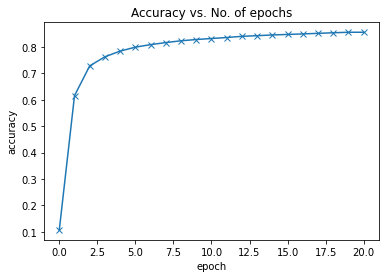

In [96]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

#**測試模型**

In [97]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [98]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb).to(device)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Shape: torch.Size([1, 28, 28])
Label: 7


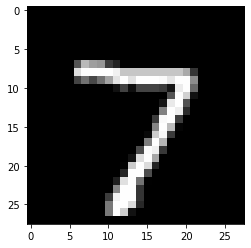

In [99]:
# Original label
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Label: 7 , Predicted: 7


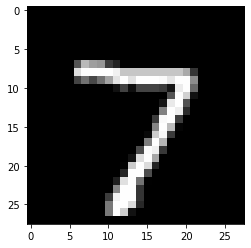

In [100]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


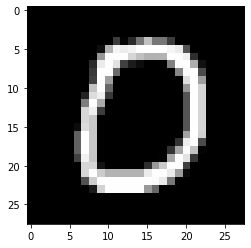

In [101]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


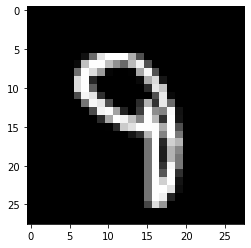

In [102]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


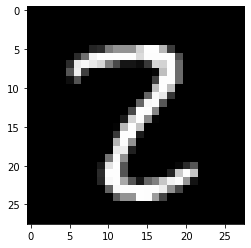

In [103]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [104]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.865039050579071, 'val_loss': 0.6393828392028809}

#**儲存模型**

In [105]:
torch.save(model.state_dict(), "hand_write_model.pt")

**讀取資料**

In [106]:
model2 = MnistModel()
model2.to(device)

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [107]:
evaluate(model2, test_loader)

{'val_acc': 0.11650390923023224, 'val_loss': 2.317927360534668}

In [109]:
model2.load_state_dict(torch.load('hand_write_model.pt'))

<All keys matched successfully>

In [110]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.865039050579071, 'val_loss': 0.6393828392028809}